# Neural Network Example

Xây dựng neural network với hai tầng ẩn (hidden layer). Các trọng số và mối liên hệ giữa các tầng ẩn được thiết lập và cài đặt bằng việc sử dụng API của thư viện PyTorch

## Neural Network Overview

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>

## MNIST Dataset Overview



In [1]:
from __future__ import absolute_import, division, print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import numpy as np

In [2]:
# Chuẩn bị dữ liệu
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Chuyển đổi sang định dạng float32.
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
# Chuẩn hóa ảnh từ from [0, 255] to [0, 1].
x_train, x_test = x_train / 255, x_test / 255
x_train, x_test, y_train, y_test = torch.from_numpy(x_train), torch.from_numpy(x_test), torch.from_numpy(y_train).type(torch.LongTensor), torch.from_numpy(y_test).type(torch.LongTensor)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
# MNIST dataset parameters.
num_classes = 10 # total classes (0-9 digits).
num_features = 784 # data features (img shape: 28*28).

# Network parameters.
n_hidden_1 = 128 # 1st layer number of neurons.
n_hidden_2 = 256 # 2nd layer number of neurons.

In [4]:
batch_size = 16

In [5]:
trainloader = []
for (i,j) in zip(x_train, y_train):
    trainloader.append([i,j])
trainloader = torch.utils.data.DataLoader(trainloader, shuffle=True, batch_size=batch_size)

testloader = []
for (i,j) in zip(x_test, y_test):
    testloader.append([i,j])
testloader = torch.utils.data.DataLoader(testloader, shuffle=True, batch_size=batch_size)

## Hiển thị một vài ví dụ

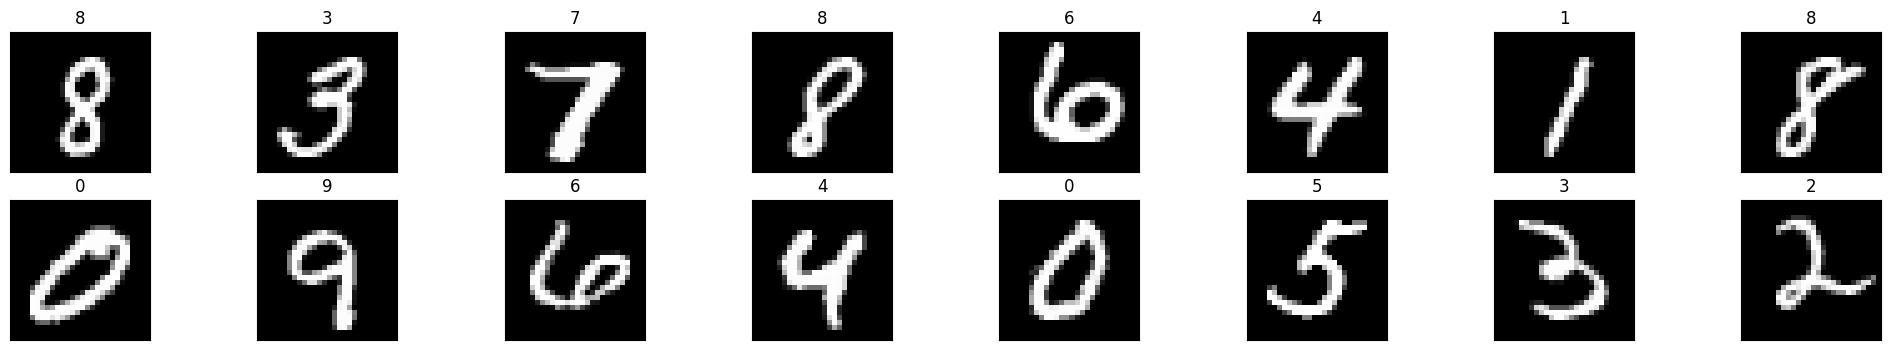

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
    
dataiter = iter(trainloader)
images, labels = next(dataiter)
images = images.numpy()

# hiển thị dữ liệu theo từng batch và nhãn tương ứng
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size//2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(str(labels[idx].item()))

In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [37]:
## định nghĩa mạng
class MLPModel(nn.Module):
    def __init__(self):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(num_features, n_hidden_1)
        # linear layer (n_hidden -> hidden_2)
        self.fc2 = nn.Linear(n_hidden_1, num_classes)

    def forward(self, x):
        # chuyển từ định dạng ma trận thành vector
        x = x.view(-1, 28 * 28)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x

# initialize the NN
model = MLPModel()
model.to(device)
print(model)

MLPModel(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [38]:
import torch.optim as optim
# trong hàm loss cross entropy đã áp dụng hàm soft max cho vector đầu ra
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [62]:
def accuracy(loader):
    correct = 0
    total = 0
    model.eval()
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            # calculate outputs by running images through the network
            outputs = model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct/total

In [42]:

losses = []
for epoch in range(50):  # loop over the dataset multiple times
    model.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    losses.append(running_loss)
    if epoch % 10 == 9:
        print('Iteration: %d, accuracy: %.3f' %(epoch + 1, accuracy(testloader)))

print('Finished Training')

Iteration: 10, accuracy: 0.973
Iteration: 20, accuracy: 0.975
Iteration: 30, accuracy: 0.978
Iteration: 40, accuracy: 0.977
Iteration: 50, accuracy: 0.979
Finished Training


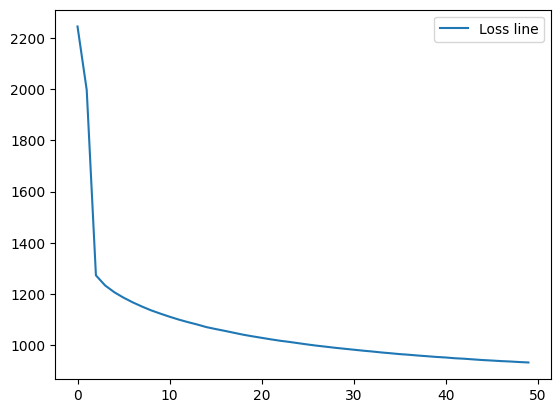

In [31]:
# Biểu đồ biểu diễn độ biến thiên của hàm mất mát qua các vòng lặp
plt.plot([i for i in range(len(losses))], losses, label='Loss line')
# plt.plot(X, np.array(W * X + b), label='Fitted line')
plt.legend()
plt.show()

## Bài tập

*   Tiến hành huấn luyện mô hình với số lượng epoch lần lượt là 50, 100, 150.Rút ra nhận xét.





*   Hiển thị một số kết quả



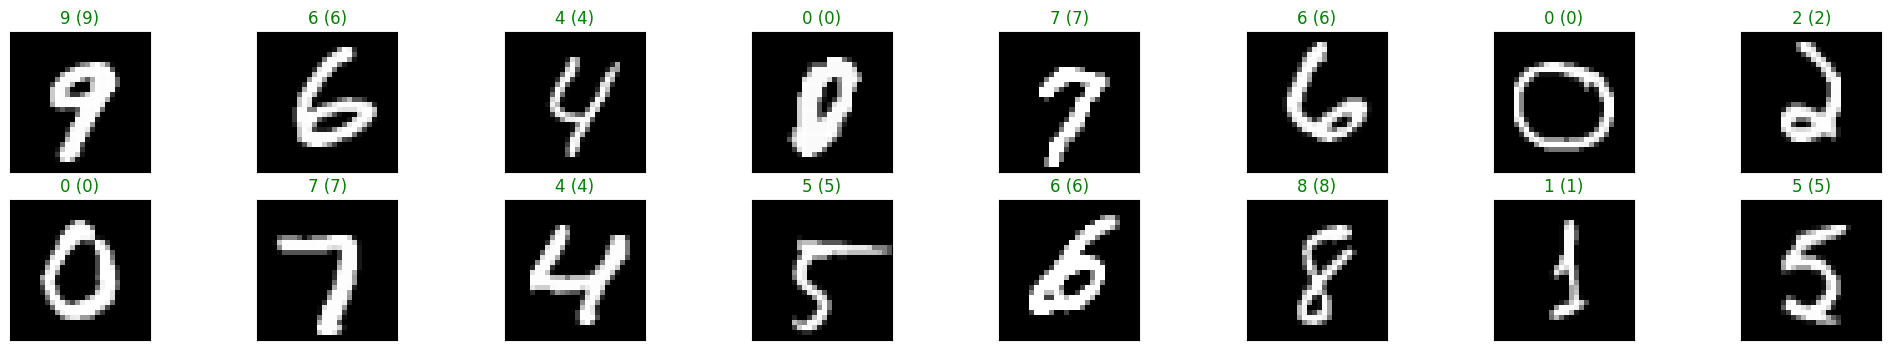

In [47]:
# obtain one batch of test images
dataiter = iter(testloader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)
# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = torch.Tensor.cpu(images).numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size//2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))

## Bài tập

*   Thiết lập thêm 3 mạng nơ ron với số tầng ẩn lần lượt là 3,5 (số lượng nơ ron của các tầng tùy ý). Với mỗi mạng mới được sinh ra, áp dụng learning-rate lần lượt bằng 0.1, 0,05, 0.001 để huấn luyện. Huấn luyện qua khoảng 100 epoch.
*   Chia tập train hiện có thành 2 phần. **85%** dữ liệu làm tập **train**, **15%** còn lại làm tập **dev**. Huấn luyện các mô hình tạo ra ở bước trên với tập **train** mới, sau đó kiểm thử trên tập **dev**. 
* Dùng các model kiểm thử trên tập **test**. So sánh model cho kết quả tốt nhất khi kiểm thử trên 2 tập này và rút ra nhận xét về vai trò của tập **dev**



In [57]:
from sklearn.model_selection import train_test_split
x_train, x_dev, y_train, y_dev = train_test_split(x_train, y_train, test_size=0.15, random_state=100)

In [58]:
trainloader = []
for (i,j) in zip(x_train, y_train):
    trainloader.append([i,j])
trainloader = torch.utils.data.DataLoader(trainloader, shuffle=True, batch_size=batch_size)

devloader = []
for (i,j) in zip(x_dev, y_dev):
    devloader.append([i,j])
devloader = torch.utils.data.DataLoader(devloader, shuffle=True, batch_size=batch_size)

In [59]:
## định nghĩa mạng
class MLPModel(nn.Module):
    def __init__(self):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(num_features, n_hidden_1)
        # linear layer (n_hidden -> hidden_2)
        self.fc2 = nn.Linear(n_hidden_1, n_hidden_2)
        self.fc3 = nn.Linear(n_hidden_2, num_classes)

    def forward(self, x):
        # chuyển từ định dạng ma trận thành vector
        x = x.view(-1, 28 * 28)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x

# initialize the NN
model = MLPModel()
model.to(device)
print(model)

MLPModel(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


In [60]:
# trong hàm loss cross entropy đã áp dụng hàm soft max cho vector đầu ra
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.05)

In [61]:
losses = []
for epoch in range(100):  # loop over the dataset multiple times
    model.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    losses.append(running_loss)
    if epoch % 10 == 9:
        print('Iteration: %d, accuracy: %.3f' %(epoch + 1, accuracy(testloader)))

print('Finished Training')

Iteration: 10, accuracy: 0.961
Iteration: 20, accuracy: 0.979
Iteration: 30, accuracy: 0.978
Iteration: 40, accuracy: 0.978
Iteration: 50, accuracy: 0.978
Iteration: 60, accuracy: 0.978
Iteration: 70, accuracy: 0.978
Iteration: 80, accuracy: 0.978
Iteration: 90, accuracy: 0.979
Iteration: 100, accuracy: 0.978
Finished Training


In [63]:
print(accuracy(devloader))

0.9769337228971244
